# Bayes Classifier. Maximum Likelihood for a multivariate Gaussian density.

## Preface

Begin, if necessary, by recalling the course notes on the [Bayes classifier](https://studium.umontreal.ca/pluginfile.php/4027948/mod_resource/content/4/7_bayes_classifier-en.pdf) and the principle of [maximum likelihood](https://studium.umontreal.ca/pluginfile.php/4003963/mod_resource/content/4/5_gaussian_distribution_en.pdf).

## High level description

Today we are going to build a **multi-class Bayes classifier**. This means that instead of modeling $ p (\mbox{class} | \mbox{example}) $ (or $ p (y | x) $), we will instead use the Bayes equation

$$ p (\mbox{class} | \mbox{example}) = \frac{p (\mbox{example} | \mbox{class}) p (\mbox {class})} {\sum_{c'= 1}^{m} p_\mbox{c'}(x) P_\mbox{c'}} $$

and model the different pieces. In fact, we just need to model the numerator since the denominator is a normalization constant. In addition, $ P_\mbox{c '} = n_c / n $

The term $ p (\mbox{class}) $ represents the prior probability of a class, that is, our a priori belief - before we have seen a particular example - about the probability that an unknown example belongs to this class). We will represent this belief a priori for a class by the frequency of the latter in the training data: $ \frac{n_c}{n} $ where $ n_c $ = number of examples of the class $ c $, and $ n $ = number of training examples.

We will use **multivariate Gaussian densities** to model the different $ p (\mbox{example} | \mbox{class}) $. This means that for each class, we will assume that the "true" distribution $ p (\mbox{example} | \mbox{class}) $ has the form of a multivariate Gaussian for which we will try to learn the parameters $ \mu $ and $ \Sigma $. In practice, we will limit ourselves today to a particular case of this distribution: the one where we assume that the covariance matrix $ \Sigma $ of each Gaussian is diagonal and that each element of this diagonal is the same, i.e. sigma_sq (<=> "sigma square" <=> $ \sigma^2 $ <=> the variance). Thus we have a single parameter to control the expression of the covariance. It's easier (for us and for the computer) to calculate, but it also means that our model is less powerful.

So we have a very simple parametric model. The parameters are the average $ \mu $ (a vector of the same dimension as the dimension of the system input) and the variance $ \sigma^2 $ (a single scalar in our simple model, which will multiply the identity matrix). Learning in this model will be done today by applying the **maximum likelihood principle**. For each class, we will find the values of the parameters that maximize the log-likelihood of the training data from this class:

$$ \log \prod_i^n p(X = x_i) $$

For an insotropic Gaussian of dimension $d$, the maximum likelihood estimators of $\mu$ and $\sigma^2$ are given by: 

$$\mu_{ML} = \frac{1}{n} \sum_{i=1}^{n} x_i$$

$$\sigma_{ML}^2 = \frac{1}{nd} \sum_{i=1}^{n} (x_i-\mu_{MV})^T(x_i-\mu_{MV})$$

Having found the parameters that maximize the likelihood for each class, we can calculate each $ p (\mbox{example} | \mbox{class}) $. It is now sufficient to apply the Bayes rule in order to classify a new example. More precisely, we want to choose, for an example, the class that maximizes $ p(\mbox{example} | \mbox{class}) p(\mbox{class}) $ or, equivalently, $ \log (p (\mbox{example } | \mbox{class} ) p(\mbox{class})) $.

## Code to be completed

Load the file `utilities.py` into the folder where your notebook files are located. It contains the useful functions you saw in the last class. You can thus use them without cluttering your notebook.

For the `gauss_ml` class:
 
  - calculate sigma_sq ($ \sigma^2 $), the variance in `gauss_ml.train`
  - calculate the value of the Gaussian density function in `gauss_ml.compute_predictions`

In [1]:
#%pylab inline
import numpy as np
import utilities

In [12]:
class gauss_ml:
    def __init__(self,n_dims,cov_type="isotropic"):
        self.n_dims = n_dims
        self.mu = np.zeros((1,n_dims))
        self.cov_type = cov_type
        
        if cov_type=="isotropic":
            self.sigma_sq = 1.0
        elif cov_type=="diagonal":
            self.sigma_sq = np.ones(n_dims)
        if cov_type=="full":
            self.cov = np.ones((n_dims,n_dims))
	# For a training set, the function should compute the ML estimator of the mean and the covariance matrix
    def train(self, train_data):
        self.mu = np.mean(train_data,axis=0)
        if self.cov_type == "isotropic":
            self.sigma_sq = np.sum((train_data - self.mu)**2.0) / (self.n_dims * train_data.shape[0])
        elif self.cov_type == "diagonale":
            self.sigma_sq =  numpy.sum((train_data - self.mu) ** 2.0, axis = 0) / train_data.shape[0] 
        if self.cov_type == "full":
            self.cov = np.cov(np.transpose(train_data))

	# Returns a vector of size nb. of test ex. containing the log
	# probabilities of each test example under the model.	
    def compute_predictions(self, test_data):

        if self.cov_type == "isotropic":
            # the following line calculates log(normalization constant)
            c = -self.n_dims * np.log(2*np.pi)/2 - self.n_dims*np.log(np.sqrt(self.sigma_sq))            
            # it is necessary to calculate the value of the log-probability of each test example 
            #under the model determined by mu and sigma_sq
            #the vector of probabilities is / will be log_prob
            log_prob = c - np.sum((test_data -  self.mu)**2.0,axis=1) / (2.0 * self.sigma_sq)
        elif self.cov_type == "diagonal":
            # we take the product of the vector representing the diagonal (np.prod(self.sigma)
            c = -self.n_dims * np.log(2*np.pi)/2.0 - np.log(np.prod(self.sigma_sq))/2.0
            # we do a summation along axis 1 after having divided by sigma because the latte is also 
            # of dimension d
            log_prob = c - np.sum((test_data -  self.mu)**2.0/ (2.0 * self.sigma_sq),axis=1)
        elif self.cov_type == "full":
            c = -self.n_dims * np.log(2.0*np.pi)/2.0
            det = np.linalg.det(self.cov)
            c += np.log(det)/2.0
            
            dmu = test_data-self.mu
            inv = np.linalg.inv(self.cov)
            
            dxs = np.dot(dmu,inv)
            dxsx = np.sum(dxs*dmu,axis=1)
            log_prob = c - dxsx
        return log_prob

For class `classif_bayes`:

  - complete `classif_bayes.compute_predictions`

In [13]:
class classif_bayes:

    def __init__(self,models_ml, priors):
        self.models_ml = models_ml
        self.priors = priors
        if len(self.models_ml) != len(self.priors):
            print('The number of ML models must be equal to the number of priors!')
        self.n_classes = len(self.models_ml)
			
    # Returns a matrix of size nb. of test ex. times number of classes containing the log
    # probabilities of each test example under each model, trained by ML.	
    def compute_predictions(self, test_data, eval_by_group=False):

        log_pred = np.empty((test_data.shape[0],self.n_classes))

        for i in range(self.n_classes):
            # Here we will have to use modeles_mv [i] and priors to fill in
            # each column of log_pred (it's more efficient to do a entire column at a time)

            log_pred[:,i] = self.models_ml[i].compute_predictions(test_data) +  np.log(self.priors[i])

        return log_pred

Complete the code by calculating the maximum per class and displaying the decision area graph using the functions in `utilities.py` 

In [14]:
# Here we provide an example where we do not divide the data into train and test set.
iris=np.loadtxt('iris.txt')
np.random.seed(123)

indices1 = np.arange(0,50)
indices2 = np.arange(50,100)
indices3 = np.arange(100,150)

np.random.shuffle(indices1)
np.random.shuffle(indices2)
np.random.shuffle(indices3)

iris_train1 = iris[indices1[:35]]
iris_test1 = iris[indices1[35:]]
iris_train2 = iris[indices2[:35]]
iris_test2 = iris[indices2[35:]]
iris_train3 = iris[indices3[:35]]
iris_test3 = iris[indices3[35:]]

iris_train = np.concatenate([iris_train1, iris_train2, iris_train3])
iris_test = np.concatenate([iris_test1, iris_test2, iris_test3])




In [15]:
# First test: with all the columns
train_cols = [0,1,2,3]

# We create a model per class (using maximum likelihood)
model_class1=gauss_ml(len(train_cols))
model_class2=gauss_ml(len(train_cols))
model_class3=gauss_ml(len(train_cols))
model_class1.train(iris_train1[:,train_cols])
model_class2.train(iris_train2[:,train_cols])
model_class3.train(iris_train3[:,train_cols])

# We create a list of all our models
# We do the same thing for the priors
# Here the priors are calculated exactly because we know the number of representatives per class. 
# Once you have created a train / test set, they need to be calculated exactly
model_ml=[model_class1,model_class2,model_class3]
priors=[0.3333,0.3333,0.3333]

# We create our classifier with our list of Gaussian models and our priors
classifier=classif_bayes(model_ml,priors)

# we can now calculate the log-probabilities according to our models
log_prob_train=classifier.compute_predictions(iris_train[:, train_cols])
log_prob_test=classifier.compute_predictions(iris_test[:, train_cols])

# it now remains to calculate the maximum per class for the classification
classesPred_train = log_prob_train.argmax(1)+1
classesPred_test = log_prob_test.argmax(1)+1

print("Error rate (training) %.2f%%" % ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0))
print("Error rate (test) %.2f%%" % ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0))

Error rate (training) 4.76%
Error rate (test) 8.89%


Error rate (training) 17.14%
Error rate (test) 20.00%


/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1194bac18>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1194baf60>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1194c1438>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-spe

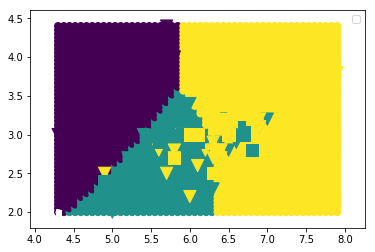

In [8]:
# Second test: only the columns 0 et 1
train_cols = [0,1]

# We create a model per class (using maximum likelihood)
model_class1=gauss_ml(len(train_cols))
model_class2=gauss_ml(len(train_cols))
model_class3=gauss_ml(len(train_cols))
model_class1.train(iris_train1[:,train_cols])
model_class2.train(iris_train2[:,train_cols])
model_class3.train(iris_train3[:,train_cols])

# We create a list of all our models
# We do the same thing for the priors
# Here the priors are calculated exactly because we know the number of representatives per class. 
# Once you have created a train / test set, they need to be calculated exactly
model_ml=[model_class1,model_class2,model_class3]
priors=[0.3333,0.3333,0.3333]

# We create our classifier with our list of Gaussian models and our priors
classifier=classif_bayes(model_ml,priors)

# we can now calculate the log-probabilities according to our models
log_prob_train=classifier.compute_predictions(iris_train[:, train_cols])
log_prob_test=classifier.compute_predictions(iris_test[:, train_cols])

# it now remains to calculate the maximum per class for the classification
classesPred_train = log_prob_train.argmax(1)+1
classesPred_test = log_prob_test.argmax(1)+1

print("Error rate (training) %.2f%%" % ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0))
print("Error rate (test) %.2f%%" % ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0))

utilities.gridplot(classifier,
                     iris_train[:, train_cols + [-1]],
                     iris_test[:, train_cols + [-1]],
                     n_points=50)

## Once you're done

- Change your code so that `gauss_ml` calculates a diagonal covariance matrix (where we estimate the variance for each component / trait of the input) or even a full covariance matrix.
- The `numpy.cov` and` numpy.var` commands will probably be useful.

In [16]:
# Premier test: avec toutes les colonnes
train_cols = [0,1,2,3]

for cov_type in ['isotropic','diagonal','full']:
    # We create a model per class (using maximum likelihood)
    model_class1=gauss_ml(len(train_cols),cov_type=cov_type)
    model_class2=gauss_ml(len(train_cols),cov_type=cov_type)
    model_class3=gauss_ml(len(train_cols),cov_type=cov_type)
    model_class1.train(iris_train1[:,train_cols])
    model_class2.train(iris_train2[:,train_cols])
    model_class3.train(iris_train3[:,train_cols])
    
    # We create a list of all our models
    # We do the same thing for the priors
    # Here the priors are calculated exactly because we know the number of representatives per class. 
    # Once you have created a train / test set, they need to be calculated exactly
    model_ml=[model_class1,model_class2,model_class3]
    priors=[0.3333,0.3333,0.3333]

    # We create our classifier with our list of Gaussian models and our priors
    classifier=classif_bayes(model_ml,priors)
    
    # we can now calculate the log-probabilities according to our models
    log_prob_train=classifier.compute_predictions(iris_train[:, train_cols])
    log_prob_test=classifier.compute_predictions(iris_test[:, train_cols])
    
    # it now remains to calculate the maximum per class for the classification
    classesPred_train = log_prob_train.argmax(1)+1
    classesPred_test = log_prob_test.argmax(1)+1
    
    print(cov_type)
    print("Error rate (training) %.2f%%" % ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0))
    print("Error rate (test) %.2f%%" % ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0))


isotropic
Error rate (training) 4.76%
Error rate (test) 8.89%
diagonal
Error rate (training) 5.71%
Error rate (test) 8.89%
full
Error rate (training) 1.90%
Error rate (test) 6.67%


isotropic
Error rate (training) 3.81%
Error rate (test) 4.44%


/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x11958c5c0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x11958c518>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x11958c978>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-spe

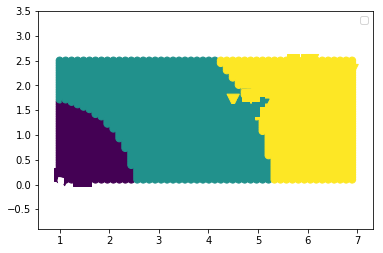

diagonal
Error rate (training) 2.86%
Error rate (test) 2.22%


/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x119e844e0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x119e847f0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x119e84c88>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-spe

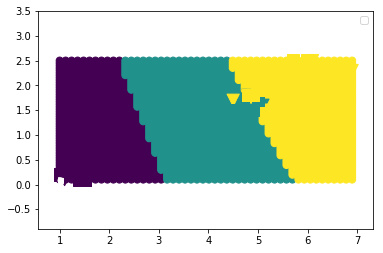

full
Error rate (training) 1.90%
Error rate (test) 2.22%


/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x119f550f0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x119f553c8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x119f55860>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-spe

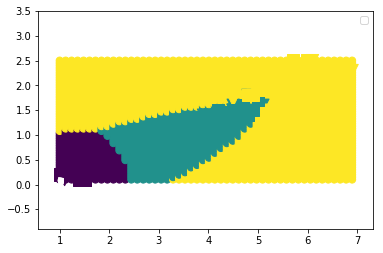

In [19]:
# Second test: only columns
train_cols = [2,3]

for cov_type in ['isotropic','diagonal','full']:
    # We create a model per class (using maximum likelihood)
    model_class1=gauss_ml(len(train_cols),cov_type=cov_type)
    model_class2=gauss_ml(len(train_cols),cov_type=cov_type)
    model_class3=gauss_ml(len(train_cols),cov_type=cov_type)
    model_class1.train(iris_train1[:,train_cols])
    model_class2.train(iris_train2[:,train_cols])
    model_class3.train(iris_train3[:,train_cols])
    
    # We create a list of all our models
    # We do the same thing for the priors
    # Here the priors are calculated exactly because we know the number of representatives per class. 
    # Once you have created a train / test set, they need to be calculated exactly
    model_ml=[model_class1,model_class2,model_class3]
    priors=[0.3333,0.3333,0.3333]

    # We create our classifier with our list of Gaussian models and our priors
    classifier=classif_bayes(model_ml,priors)
    
    # we can now calculate the log-probabilities according to our models
    log_prob_train=classifier.compute_predictions(iris_train[:, train_cols])
    log_prob_test=classifier.compute_predictions(iris_test[:, train_cols])
    
    # it now remains to calculate the maximum per class for the classification
    classesPred_train = log_prob_train.argmax(1)+1
    classesPred_test = log_prob_test.argmax(1)+1
    
    print(cov_type)
    print("Error rate (training) %.2f%%" % ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0))
    print("Error rate (test) %.2f%%" % ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0))

    utilities.gridplot(classifier,
                         iris_train[:, train_cols + [-1]],
                         iris_test[:, train_cols + [-1]],
                         n_points=50)